In [20]:
import torch
import torch.nn.functional as F

def upsample_cam_custom(cam, upsample_size):
    """
    cam: [H_in, W_in]  的 2D CAM
    upsample_size: (H_out, W_out)
    
    逻辑：
    1. 把 H_in 行线性映射到 H_out 里的某些整数行上（类似“拉伸”）
    2. 对没被占的行，在高度方向做线性插值填充
    3. 宽度再用 F.interpolate 放大到 W_out
    """
    device = cam.device
    H_in, W_in = cam.shape
    H_out, W_out = upsample_size

    # ---- 1. 先只在高度方向做“线性映射到指定位置” ----
    # 计算每一行应该落在 H_out 的哪一行（线性映射）
    # 0..H_in-1  →  0..H_out-1
    target_pos = torch.linspace(0, H_out - 1, H_in, device=device)  # float
    target_idx = target_pos.round().long().clamp(0, H_out - 1)      # 整数行索引

    # 新的 [H_out, W_in]，先全设为 NaN 表示“没有数值”
    cam_h = torch.full((H_out, W_in), float("nan"), device=device)

    # 把每一行放到对应位置上
    for src_i, dst_i in enumerate(target_idx):
        cam_h[dst_i] = cam[src_i]

    # ---- 2. 对没有值的行，在高度方向线性插值填充 ----
    valid = ~torch.isnan(cam_h).any(dim=1)          # 哪些行有原始数据
    idx_valid = torch.nonzero(valid, as_tuple=False).squeeze(1)

    # 如果极端情况 H_out < H_in 之类，这里防御一下
    if len(idx_valid) == 0:
        # 全 NaN 就直接最近邻插值
        cam_h = F.interpolate(
            cam.unsqueeze(0).unsqueeze(0),
            size=(H_out, W_in),
            mode="nearest",
        )[0, 0]
    else:
        # 前面空的部分用第一行填
        first = idx_valid[0].item()
        for j in range(0, first):
            cam_h[j] = cam_h[first]

        # 中间的 gap 做线性插值
        for k in range(len(idx_valid) - 1):
            a = idx_valid[k].item()
            b = idx_valid[k + 1].item()
            if b == a + 1:
                continue
            for j in range(a + 1, b):
                t = (j - a) / (b - a)
                cam_h[j] = (1 - t) * cam_h[a] + t * cam_h[b]

        # 后面空的部分用最后一行填
        last = idx_valid[-1].item()
        for j in range(last + 1, H_out):
            cam_h[j] = cam_h[last]

    # ---- 3. 再在宽度方向插值到目标 W_out ----
    cam_out = F.interpolate(
        cam_h.unsqueeze(0).unsqueeze(0),    # [1,1,H_out,W_in]
        size=(H_out, W_out),
        mode="bilinear",
        align_corners=True,
    )[0, 0]

    return cam_out


In [36]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tqdm import tqdm

from dataset import CRSP20
from models.baseline import CNN_BASELINE
from tools import get_current_path, load_checkpoint

# ===================== GradCAM 实现 =====================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # forward hook: 存 feature map
        self.fwd_hook = target_layer.register_forward_hook(self._forward_hook)
        # backward hook: 存梯度（用 full_backward_hook 避免 warning）
        self.bwd_hook = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        # out: [B, C, H, W]
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        # grad_out[0]: [B, C, H, W]
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, target_class=None, upsample_size=None):
        """
        input_tensor: [1, 1, H, W]
        返回 cam: [h, w] or 上采样后的 [H, W]
        """
        self.model.zero_grad()
        output = self.model(input_tensor)  # [1, num_classes]

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        score = output[0, target_class]
        score.backward()
        # loss = F.cross_entropy(output, torch.tensor([target_class], device=output.device))
        # loss.backward()


        A = self.activations     # [1, C, h, w]
        G = self.gradients       # [1, C, h, w]


        # print('A:', A.shape, A.min().item(), A.max().item())
        # print('G:', G )


        # 通道权重 alpha_k = 平均梯度
        alpha = G.mean(dim=(0, 2, 3))  # [C]

        # 加权求和得到 cam
        cam = torch.zeros(A.shape[2:], device=A.device)  # [h, w]
        for c in range(A.shape[1]):
            cam += alpha[c] * A[0, c]

        cam = F.relu(cam)
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        if upsample_size is not None:
            cam = F.interpolate(
                cam.unsqueeze(0).unsqueeze(0),
                size=upsample_size,
                mode="bilinear",
                align_corners=True,
            )[0, 0]
        # if upsample_size is not None:
        #     cam = upsample_cam_custom(cam, upsample_size)


            
        return cam.detach().cpu()



In [2]:


# ---- 1. 路径 & 设备 ----
current_path = get_current_path()
data_path = os.path.join(current_path, "./img_data/monthly_20d")
model_path = os.path.join(current_path, "./result_best/best_model.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- 3. 加载测试集 ----
test_dataset = CRSP20(data_path, split="test")
print("len(test_dataset):", len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=2048,
                            shuffle=True, pin_memory=True)

loading dataset, year = 2011
loading dataset, year = 2000
loading dataset, year = 2019
loading dataset, year = 2005
loading dataset, year = 2014
loading dataset, year = 2008
loading dataset, year = 2013
loading dataset, year = 2002
loading dataset, year = 2007
loading dataset, year = 2016
loading dataset, year = 2018
loading dataset, year = 2004
loading dataset, year = 2015
loading dataset, year = 2009
loading dataset, year = 2010
loading dataset, year = 2001
loading dataset, year = 2006
loading dataset, year = 2017
loading dataset, year = 2012
loading dataset, year = 2003


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]

len(test_dataset): 1490937


In [7]:



# ---- 2. 加载模型权重 ----
model = CNN_BASELINE().to(device)
model, _, epoch,_,_ = load_checkpoint(model_path, model)
model.eval()
model.softmax = torch.nn.Identity()
print(f"The model parameters have been loaded onto the device:{device}")
print(f"Loaded epoch: {epoch}")


print(model)
print("conv1 stride =", model.layer1[0].stride)
print("conv1 padding =", model.layer1[0].padding)
print("conv1 dilation =", model.layer1[0].dilation)

# ---- 4. 跑一遍模型，挑出预测为 up / down 的样本各若干张 ----
preds_up = []    # 存图像 Tensor
preds_down = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        # imgs: [B, H, W]，先加通道
        x = imgs.unsqueeze(1).to(device)    # [B,1,64,60]
        out = model(x)                      # [B,2]
        pred = out.argmax(dim=1).cpu()      # [B]

        for img, p in zip(imgs, pred):
            if p.item() == 1:
                preds_up.append(img)
            else:
                preds_down.append(img)

        # 够用了就可以停（比如各 10 张）
        if len(preds_up) >= 10 and len(preds_down) >= 10:
            break




The model parameters have been loaded onto the device:cpu
no optimizer parameters loaded
The model parameters have been loaded onto the device:cpu
Loaded epoch: 8
CNN_BASELINE(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dila

  0%|          | 0/728 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/course_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/728 [00:06<?, ?it/s]


In [8]:
# ===================== 检查每一层 Conv2d 激活尺寸 =====================

import torch
from collections import OrderedDict

# 取一张样本图像（preds_up 或 preds_down 都可以）
sample_img = preds_up[0].unsqueeze(0).unsqueeze(0).to(device)    # [1,1,64,60]

# 我们需要 hook 到每个 Conv2d 的输出
conv_layers = OrderedDict({
    "Conv1": model.layer1[0],   # Conv2d(1→64)
    "Conv2": model.layer2[0],   # Conv2d(64→128)
    "Conv3": model.layer3[0],   # Conv2d(128→256)
})

activations = {}

def make_hook(name):
    def hook(module, inp, out):
        activations[name] = out.detach().cpu()
    return hook

# 注册 hook
hooks = []
for name, layer in conv_layers.items():
    h = layer.register_forward_hook(make_hook(name))
    hooks.append(h)

# 运行一次前向传播
_ = model.forward_logits(sample_img) if hasattr(model, "forward_logits") else model(sample_img)

# 打印每个 Conv2d 输出尺寸
for name, act in activations.items():
    print(f"{name} output shape: {tuple(act.shape)}")

# 清除 hook
for h in hooks:
    h.remove()


Conv1 output shape: (1, 64, 27, 60)
Conv2 output shape: (1, 128, 10, 60)
Conv3 output shape: (1, 256, 7, 60)


/var/folders/s9/dwmbdjrn0rsdf992gy9545_m0000gn/T/ipykernel_15669/3624171088.py:49: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  score.backward()


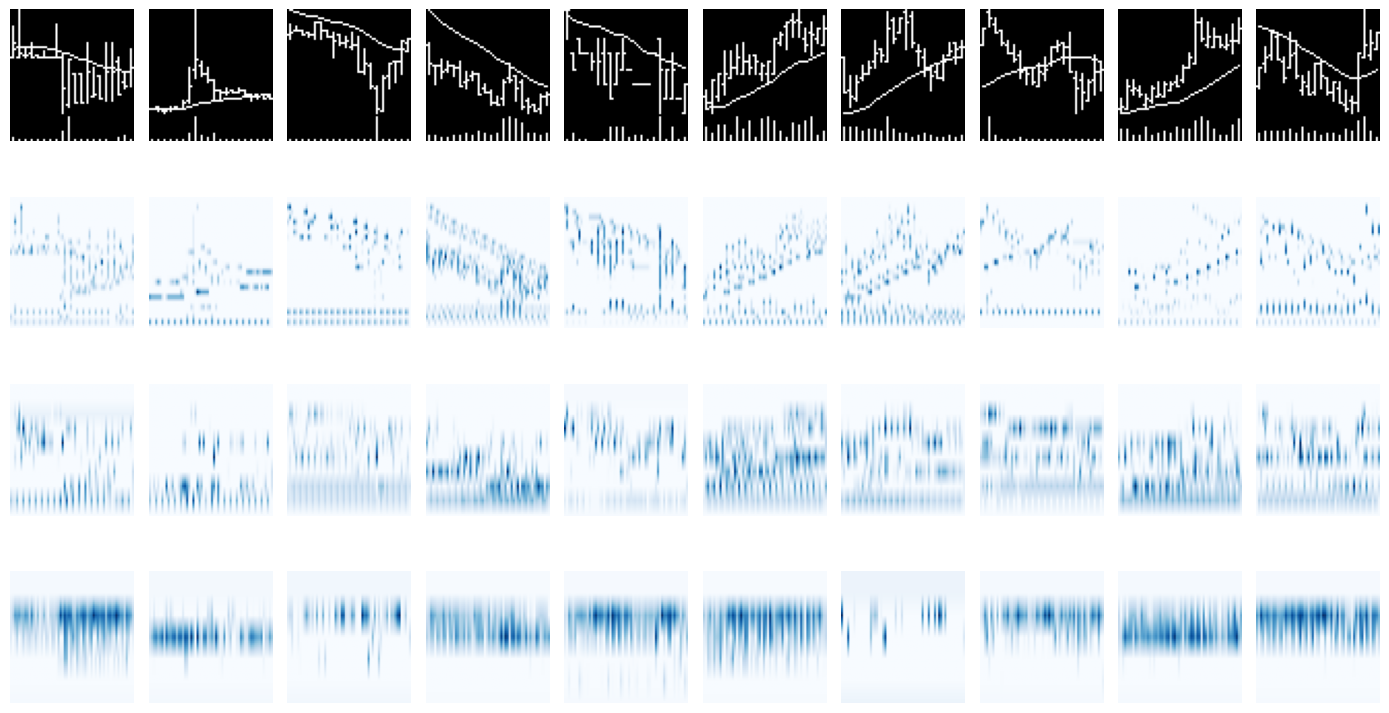

In [ ]:



# ===================== 每层的 colormap =====================

black_blue = mcolors.LinearSegmentedColormap.from_list(
    "black_blue",
    [ "#000000", "#00e1ff","#ffffff"],
)


layer_cmaps = {
    "L1": black_blue,
    "L2": black_blue,
    "L3": black_blue,
}


layers = {
    "L1": model.layer1[0],   # Conv2d
    "L2": model.layer2[0],   # Conv2d
    "L3": model.layer3[0],   # Conv2d
}

# ===================== 画 Figure13 风格图 =====================

def plot_figure13_style(samples, title, model, layers, device):
    n = len(samples)
    H, W = 64, 60
    layer_names = list(layers.keys())

    plt.figure(figsize=(14, 8))

    for col, img in enumerate(samples):
        img_tensor = img.unsqueeze(0).unsqueeze(0).to(device)

        # Row 1: 原图（黑底 K 线）
        ax = plt.subplot(4, n, col + 1)
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.axis("off")
        if col == 0:
            ax.set_ylabel("Input", fontsize=12)

        # Row 2/3/4: 各层 Grad-CAM
        for r, name in enumerate(layer_names):
            cam = GradCAM(model, layers[name]).generate(
                img_tensor, upsample_size=(H, W)
            )
            

            ax = plt.subplot(4, n, (r + 1) * n + col + 1)
            ax.imshow(
                cam.numpy(),
                cmap="Blues",
                vmin=0.0,
                vmax=1.0,
            )
            
            ax.axis("off")
            if col == 0:
                ax.set_ylabel(name, fontsize=11)

    # plt.suptitle(title, fontsize=16)
    plt.tight_layout()



preds_up_clip = preds_up[:10]
preds_down_clip = preds_down[:10]

# print(f"Collected {len(preds_up)} up samples, {len(preds_down)} down samples.")

plot_figure13_style(preds_up_clip, "Up Classification", model, layers, device)
plt.savefig("up_classification.png", dpi=300, bbox_inches="tight")


plot_figure13_style(preds_down_clip, "Down Classification", model, layers, device)
plt.savefig("down_classification.png", dpi=300, bbox_inches="tight")
